In [1]:
# Local utilities
from util import *
environment_check()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available
Tensor on GPU: tensor([1., 2., 3.], device='cuda:0')

PyTorch3D is using CUDA


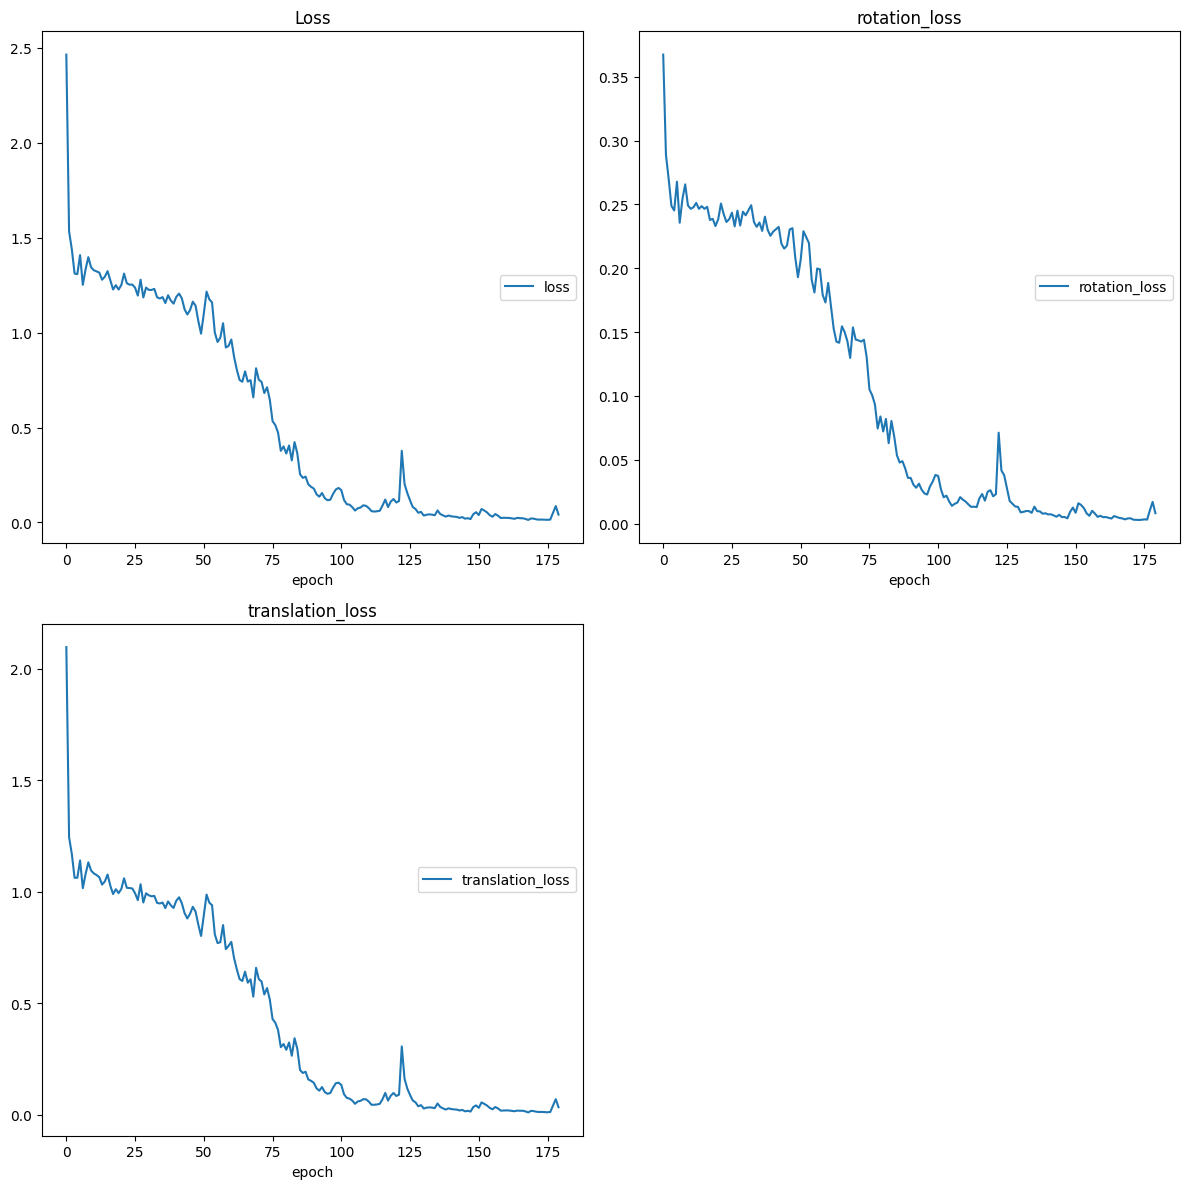

Loss
	loss             	 (min:    0.013, max:    2.464, cur:    0.041)
rotation_loss
	rotation_loss    	 (min:    0.003, max:    0.367, cur:    0.008)
translation_loss
	translation_loss 	 (min:    0.010, max:    2.096, cur:    0.033)


In [ ]:
import torch
import json
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.optim import Adam
import logging
import torch
import json
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class PoseRefinementDataset(torch.utils.data.Dataset):
    def __init__(self, data_json_filepath):
        with open(data_json_filepath, 'r') as f:
            self.data_json = json.load(f)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        logging.info("Dataset loaded with {} samples".format(len(self.data_json)))

    def __len__(self):
        return len(self.data_json)

    def __getitem__(self, idx):
        entry = self.data_json[idx]
        image = Image.open(entry['silhouette_path']).convert('L').convert('RGB')
        image = self.transform(image)
        rt_matrix = torch.tensor(entry['RT'], dtype=torch.float32)
        if rt_matrix.numel() == 16:
            rt_matrix = rt_matrix.view(4, 4)[:-1]  # Assuming the last row is [0, 0, 0, 1] and can be discarded
        else:
            rt_matrix = rt_matrix.view(3, 4)  # Normal case
        logging.debug(f"Image and RT matrix loaded for index {idx}")
        return image, rt_matrix
    
    def show_sample(self, idx):
        image, rt_matrix = self.__getitem__(idx)
        image_np = image.numpy().transpose((1, 2, 0))
        image_np = np.clip(image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(image_np)
        plt.title(f"Sample {idx} - RT Matrix: \n{rt_matrix.numpy()}")
        plt.show()    

# Example usage to display a sample from the dataset
dataset = PoseRefinementDataset("./pose_refine_dataset/dataset_info.json")
dataset.show_sample(0)  # Display the first sample
        
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import vit_b_32, ViT_B_32_Weights
# import logging

# class ViTImageToRTNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # CNN Layer to be added before the ViT model
#         self.cnn_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        
#         # ViT model setup, changed to use vit_b_32 with the default weights
#         self.vit = vit_b_32(weights=ViT_B_32_Weights.DEFAULT)  # Changed to vit_b_32
#         self.vit.heads = nn.Identity()  # Remove the classifier head
        
#         # Regression layers
#         self.rotation_regressor = nn.Linear(768, 9)  # Assuming 768-dimensional output from ViT model
#         self.translation_regressor = nn.Linear(768, 3)  # Assuming the same for consistency

#         logging.info("ViT model initialized with removed classifier head, regressors added, and preceding CNN layer")

#     def forward(self, x):
#         # Pass input through CNN layer first
#         x = self.cnn_layer(x)
        
#         # Pass the output of CNN to ViT model
#         features = self.vit(x)
#         cls_token = features
        
#         # Compute rotation and translation
#         rotation = self.rotation_regressor(cls_token).view(-1, 3, 3)
#         translation = self.translation_regressor(cls_token).view(-1, 3, 1)
        
#         # Concatenate to form the RT matrix
#         rt_matrix = torch.cat((rotation, translation), dim=2)
#         logging.debug("Model forward pass completed")
#         return rt_matrix

#     def load_model_weights(self, weight_path):
#         # Load the entire model state from a .pth file
#         self.load_state_dict(torch.load(weight_path))
#         logging.info(f"Loaded entire model weights from {weight_path}")
        
        
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vit_b_32, ViT_B_32_Weights
import logging

class ViTImageToRTNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN Layer to be added before the ViT model
        self.cnn_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        
        # Dropout layer added after CNN
        self.dropout = nn.Dropout(p=0.5)  # Dropout probability is 50%

        # ViT model setup, using vit_b_32 with the default weights
        self.vit = vit_b_32(weights=ViT_B_32_Weights.DEFAULT)
        self.vit.heads = nn.Identity()  # Remove the classifier head
        
        # Regression layers
        self.rotation_regressor = nn.Linear(768, 9)  # Assuming 768-dimensional output from ViT model
        self.translation_regressor = nn.Linear(768, 3)  # Assuming the same for consistency

        logging.info("ViT model initialized with removed classifier head, regressors added, and preceding CNN layer with dropout")

    def forward(self, x):
        # Pass input through CNN layer first
        x = self.cnn_layer(x)

        # Apply dropout to the output of the CNN layer
        x = self.dropout(x)
        
        # Pass the output of CNN with dropout applied to the ViT model
        features = self.vit(x)
        cls_token = features
        
        # Compute rotation and translation
        rotation = self.rotation_regressor(cls_token).view(-1, 3, 3)
        translation = self.translation_regressor(cls_token).view(-1, 3, 1)
        
        # Concatenate to form the RT matrix
        rt_matrix = torch.cat((rotation, translation), dim=2)
        logging.debug("Model forward pass completed")
        return rt_matrix

    def load_model_weights(self, weight_path):
        # Load the entire model state from a .pth file
        self.load_state_dict(torch.load(weight_path))
        logging.info(f"Loaded entire model weights from {weight_path}")

# Setup logging
logging.basicConfig(level=logging.DEBUG)

# Example of creating and using the model
# model = ViTImageToRTNetwork()
# Example input tensor
# input_tensor = torch.rand(1, 3, 224, 224)  # Example input size for ViT
# output = model(input_tensor)
# print(output)
        

# import torch
# import torch.nn as nn
# from torchvision.models import resnet50, ResNet50_Weights, vit_b_32, ViT_B_32_Weights
# import logging

# class ViTImageToRTNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Initialize ResNet-50 as the feature extractor, removing the fully connected layer
#         self.feature_extractor = resnet50(weights=ResNet50_Weights.DEFAULT)
#         self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])

#         # Additional layer to adjust channel dimensions from 2048 to 3 using a 1x1 convolution
#         self.channel_adjust = nn.Conv2d(2048, 3, kernel_size=1)

#         # Set Adaptive Pooling to match ViT's expected input size of 224x224
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((224, 224))

#         # Initialize Vision Transformer (ViT) with the expected image size
#         self.vit = vit_b_32(weights=ViT_B_32_Weights.DEFAULT, image_size=224)
#         self.vit.heads = nn.Identity()  # Remove the classifier head

#         # Assuming ViT outputs 768 features
#         self.rotation_regressor = nn.Linear(768, 9)
#         self.translation_regressor = nn.Linear(768, 3)

#         logging.info("ViT model initialized with ResNet-50 for feature extraction, channel adjustment, and ViT as regressor")

#     def forward(self, x):
#         logging.debug(f"Input shape: {x.shape}")

#         # Pass input through the ResNet-50 feature extractor
#         x = self.feature_extractor(x)
#         logging.debug(f"Output after ResNet-50: {x.shape}")

#         # Adjust channel dimensions to match the ViT's expected input
#         x = self.channel_adjust(x)
#         logging.debug(f"Output after channel adjustment: {x.shape}")

#         # Adaptive pooling to create a suitable input for ViT
#         x = self.adaptive_pool(x)
#         logging.debug(f"Output after adaptive pooling: {x.shape}")

#         # Pass the prepared features into ViT
#         features = self.vit(x)
#         logging.debug(f"Output after ViT: {features.shape}")

#         # Compute rotation and translation from ViT features
#         rotation = self.rotation_regressor(features).view(-1, 3, 3)
#         translation = self.translation_regressor(features).view(-1, 3, 1)

#         # Concatenate rotation and translation matrices to form the RT matrix
#         rt_matrix = torch.cat((rotation, translation), dim=2)
#         logging.debug("Model forward pass completed")

#         return rt_matrix

#     def load_model_weights(self, weight_path):
#         # Load model state from a .pth file
#         self.load_state_dict(torch.load(weight_path))
#         logging.info(f"Loaded model weights from {weight_path}")

# logging.basicConfig(level=logging.DEBUG)  # Set logging level to DEBUG to ensure all debug statements are captured




from livelossplot import PlotLosses
def train_model(dataset, epochs, batch_size, learning_rate, model_save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = ViTImageToRTNetwork().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    liveloss = PlotLosses()
    rotation_loss_fn = nn.MSELoss()
    translation_loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        logs = {}
        model.train()
        total_loss, total_rotation_loss, total_translation_loss = 0, 0, 0
        for images, rt_matrices in loader:
            images = images.to(device)
            rt_matrices = rt_matrices.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            pred_rotation = outputs[:, :, :3]
            pred_translation = outputs[:, :, 3:]

            true_rotation = rt_matrices[:, :, :3]
            true_translation = rt_matrices[:, :, 3:]

            loss_rotation = rotation_loss_fn(pred_rotation, true_rotation)
            loss_translation = translation_loss_fn(pred_translation, true_translation)

            loss = loss_rotation + loss_translation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_rotation_loss += loss_rotation.item()
            total_translation_loss += loss_translation.item()

        logs['loss'] = total_loss / len(loader)
        logs['rotation_loss'] = total_rotation_loss / len(loader)
        logs['translation_loss'] = total_translation_loss / len(loader)
        liveloss.update(logs)
        liveloss.send()

        # Save checkpoint after each epoch
        #torch.save(model.state_dict(), model_save_path.format(epoch))

    # No need for liveloss.close(), so it's removed.

    # Save final model
    torch.save(model.state_dict(), model_save_path.format('final'))


def evaluate_model(dataset, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTImageToRTNetwork().to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.MSELoss()
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, rt_matrices in loader:
            images, rt_matrices = images.to(device), rt_matrices.to(device)
            outputs = model(images)
            loss = criterion(outputs, rt_matrices)
            total_loss += loss.item()
    logging.info(f"Validation Loss: {total_loss / len(loader)}")
# Example usage
dataset = PoseRefinementDataset("./pose_refine_dataset/dataset_info.json")
model_save_path = "./pose_refine_dataset/pose_refine_model_epoch_{}.pth"  # Path where you want to save the model weights
train_model(dataset, epochs=3000, batch_size=8, learning_rate=0.001, model_save_path=model_save_path)

 


In [ ]:
dataset_path = "./pose_refine_dataset_e/dataset_info.json"
dataset_e = PoseRefinementDataset(dataset_path)
evaluate_model(dataset_e, batch_size=4)

In [ ]:
import torch
device = torch.device("cpu")
# Assuming the necessary imports are done and device is defined
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

def display_input_image(img_input):
    """
    Display the input image.

    Parameters:
    - img_input: A PyTorch tensor representing the image to be displayed.
    """
    # Convert the PyTorch tensor to a NumPy array and transpose the axes for displaying
    img_np = img_input.cpu().detach().numpy()
    plt.imshow(img_np.transpose(1, 2, 0))
    plt.title("Input Image")
    plt.axis('off')  # Hide axis for cleaner visualization
    plt.show()

def visualize_meshes(mesh_pred):
    """
    Create visualizations for the predicted mesh.

    Parameters:
    - mesh_pred: A PyTorch3D Meshes object representing the predicted mesh.
    """
    # Get vertices and faces from the predicted mesh
    verts, faces = mesh_pred.get_mesh_verts_faces(0)
    original_verts = verts.detach().numpy()
    i, j, k = faces[:, 0].detach().numpy(), faces[:, 1].detach().numpy(), faces[:, 2].detach().numpy()

    # Define the camera view
    camera_view = dict(
        eye=dict(x=0.0, y=0.0, z=2.0),
        up=dict(x=0, y=1, z=0),
        center=dict(x=0, y=0, z=0),
        projection=dict(type='perspective')
    )

    # Create subplot figures for the predicted mesh
    fig = make_subplots(
        rows=1, cols=1,
        specs=[[{'type': 'surface'}]],
        subplot_titles=('Predicted Mesh',)
    )

    # Add predicted mesh to the subplot
    fig.add_trace(
        go.Mesh3d(
            x=original_verts[:, 0], 
            y=original_verts[:, 1], 
            z=original_verts[:, 2], 
            i=i, 
            j=j, 
            k=k, 
            colorscale='Viridis', 
            opacity=0.50
        )
    )

    # Update layout for the subplot
    fig.update_layout(
        autosize=False,
        width=800,  # Adjusted for a single mesh visualization
        height=600,
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="white",
        scene_camera=camera_view
    )
    
    # Show the subplot figure
    fig.show()
    
def visualize_mesh_with_cameras(mesh_gt, camera_poses):
    """
    Visualize the ground truth mesh along with camera frustums to indicate camera positions and orientations.
    """
    camera_view = dict(eye=dict(x=0.0, y=0.0, z=2.0), center=dict(x=0, y=0, z=0),
                       up=dict(x=0, y=1, z=0), projection=dict(type='perspective'))
    scene_layout = dict(xaxis=dict(range=[-3, 3]), yaxis=dict(range=[-3, 3]),
                        zaxis=dict(range=[-3, 3]), camera=camera_view, aspectmode='cube')

    verts_gt, faces_gt = mesh_gt.get_mesh_verts_faces(0)
    mesh_trace_gt = go.Mesh3d(x=verts_gt[:, 0], y=verts_gt[:, 1], z=verts_gt[:, 2],
                              i=faces_gt[:, 0], j=faces_gt[:, 1], k=faces_gt[:, 2],
                              color='lightblue', opacity=0.5, name='GT Mesh')

    fig = go.Figure(data=[mesh_trace_gt])

    for index, RT in enumerate(camera_poses):
        # Decompose the RT matrix to extract the position and the forward vector.
        camera_position = RT[:3, 3].numpy()
        forward_vector = RT[:3, 2].numpy()  # Forward direction (Z-axis)
        end_point = camera_position + forward_vector * 0.3  # Scale the length of the arrow

        # Add the camera position as a dot
        fig.add_trace(go.Scatter3d(
            x=[camera_position[0]],
            y=[camera_position[1]],
            z=[camera_position[2]],
            mode='markers',
            marker=dict(size=5, color='blue'),
            name=f'Camera {index + 1}'
        ))

        # Add an arrow to represent the orientation
        fig.add_trace(go.Scatter3d(
            x=[camera_position[0], end_point[0]],
            y=[camera_position[1], end_point[1]],
            z=[camera_position[2], end_point[2]],
            mode='lines+markers',
            marker=dict(size=2, color='red'),
            line=dict(color='red', width=2),
            showlegend=False
        ))

        # Optionally, add cones to act as arrowheads
        fig.add_trace(go.Cone(
            x=[end_point[0]],
            y=[end_point[1]],
            z=[end_point[2]],
            u=[forward_vector[0]],
            v=[forward_vector[1]],
            w=[forward_vector[2]],
            sizemode='absolute',
            sizeref=0.1,
            anchor='tip',
            showscale=False,
            colorscale=[[0, 'red'], [1, 'red']],
            name=f'Orientation {index + 1}'
        ))

    fig.update_layout(title="Ground Truth Mesh with Camera Frustums", scene=scene_layout, autosize=False,
                      width=800, height=600, margin=dict(l=50, r=50, b=50, t=50))
    fig.show()


In [ ]:
import torch
from pytorch3d.io import load_objs_as_meshes

# Set the device for PyTorch (assumes PyTorch and PyTorch3D are installed and configured)
device = torch.device("cpu")

# Full path to the mesh file
mesh_path = './pose_refine_dataset/meshes/mesh_0.obj'

# Load the mesh file into a PyTorch3D Meshes object
mesh_gt = load_objs_as_meshes([mesh_path], device=device)


# Example usage:
model = ViTImageToRTNetwork()
model.load_model_weights('./pose_refine_dataset/pose_refine_model_epoch_final.pth')

# Assuming dataset is already defined and properly loaded
sample_index = 5  # Get the first sample, for example
image, gt_rt_matrix = dataset_e[sample_index]

# Log the requires_grad status for image and gt_rt_matrix
print(f"image requires_grad: {image.requires_grad}")
print(f"gt_rt_matrix requires_grad: {gt_rt_matrix.requires_grad}")

# Display the input image
display_input_image(image)

# Move image to the device model is on and add batch dimension if necessary
device = next(model.parameters()).device
image = image.unsqueeze(0).to(device)

# Log the requires_grad status after moving to the device
print(f"image after device transfer requires_grad: {image.requires_grad}")

predicted_rt_matrix = model(image)

# Detach the tensor and move it to CPU for further processing without gradients
predicted_rt_matrix = predicted_rt_matrix.detach().cpu()

# Log the requires_grad status for predicted_rt_matrix
print(f"predicted_rt_matrix requires_grad: {predicted_rt_matrix.requires_grad}")

# Visualize the ground truth mesh with predicted camera poses
# Assuming 'mesh_gt' and 'predicted_rt_matrix' are available
visualize_mesh_with_cameras(mesh_gt, [predicted_rt_matrix.squeeze(0), gt_rt_matrix])
